# Linear Regression Model

This notebook builds a time-safe Logistic Regression model to predict project success.

In [1]:
# Initial imports
import sys
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix,
    precision_recall_curve
)

import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


## Load Prepared Data

We'll recreate the preprocessing steps from `02_feature_engineering.ipynb` to get our train/test splits.


In [2]:
# Get the project root
curr_dir = Path.cwd()
project_root = curr_dir.parent.parent
sys.path.append(str(project_root))

# Load cleaned data
cleaned_path = project_root / "data" / "cleaned" / "kickstarter_cleaned.csv"

# Load cleaned data
df = pd.read_csv(cleaned_path, encoding='latin-1', low_memory=False)
print(f"Loaded cleaned dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Convert launched to datetime
df['launched'] = pd.to_datetime(df['launched'], errors='coerce')
df['deadline'] = pd.to_datetime(df['deadline'], errors='coerce')

# Filter only on launch-time valid fields (NOT pledged/backers)
df = df[df['usd_goal_real'] > 0].copy()
df = df[df['launched'].notna()].copy()
df = df[df['deadline'].notna()].copy()

print(f"\nAfter filtering (goal > 0, valid dates): {df.shape[0]:,} rows")
print("Target distribution:")
print(df['target'].value_counts())
print(f"Success rate: {df['target'].mean():.2%}")


Loaded cleaned dataset: 331,675 rows × 10 columns

After filtering (goal > 0, valid dates): 331,675 rows
Target distribution:
target
0    197719
1    133956
Name: count, dtype: int64
Success rate: 40.39%


## Feature Engineering - Launch-Time Features

We'll create features that are all available at launch time:
- Time features (weekday, month)
- Goal context (log goal, goal per day)
- Category and continent features


## Feature Engineering (Recreate from 02_feature_engineering.ipynb)

We'll recreate the same preprocessing steps to ensure consistency.


In [3]:
# Step 1: Create basic categorical features BEFORE time split
# These don't depend on aggregates, so it is safe to create before splitting

# Create main_category_grouped
category_map = {
    'Art': 'Creative', 'Comics': 'Creative', 'Crafts': 'Creative',
    'Dance': 'Creative', 'Design': 'Creative',
    'Fashion': 'Consumer', 'Food': 'Consumer',
    'Film & Video': 'Entertainment', 'Games': 'Entertainment',
    'Music': 'Entertainment', 'Theater': 'Entertainment',
    'Photography': 'Creative', 'Publishing': 'Creative',
    'Technology': 'Tech', 'Journalism': 'Other'
}
df['main_category_grouped'] = df['main_category'].map(category_map).fillna('Other')

# Create continent
continent_map = {
    'US': 'North America', 'CA': 'North America', 'MX': 'North America',
    'GB': 'Europe', 'DE': 'Europe', 'FR': 'Europe', 'IT': 'Europe',
    'ES': 'Europe', 'NL': 'Europe', 'IE': 'Europe', 'SE': 'Europe',
    'CH': 'Europe', 'AT': 'Europe', 'DK': 'Europe', 'BE': 'Europe',
    'LU': 'Europe', 'NO': 'Europe',
    'AU': 'Oceania', 'NZ': 'Oceania',
    'JP': 'Asia', 'SG': 'Asia', 'HK': 'Asia'
}
df['continent'] = df['country'].map(continent_map).fillna('Other')

# Create month features (from launch/deadline dates)
df['launched_month'] = df['launched'].dt.month
df['deadline_month'] = df['deadline'].dt.month

# Add weekday feature
df['launched_weekday'] = df['launched'].dt.weekday

print("Created basic categorical features:")
print(f"  - main_category_grouped: {df['main_category_grouped'].nunique()} categories")
print(f"  - continent: {df['continent'].nunique()} categories")
print(f"  - launched_month: {df['launched_month'].nunique()} months (1-12)")
print(f"  - launched_weekday: {df['launched_weekday'].nunique()} weekdays (0=Monday, 6=Sunday)")

# Step 2: Time based split
# Sort by launch date
df_sorted = df.sort_values('launched').copy()

# Use 70% earliest projects for training, 30% latest for testing
split_idx = int(len(df_sorted) * 0.7)
df_train_raw = df_sorted.iloc[:split_idx].copy()
df_test_raw = df_sorted.iloc[split_idx:].copy()

print("\nTime-based split:")
print(f"Train: {df_train_raw['launched'].min()} to {df_train_raw['launched'].max()}")
print(f"Test:  {df_test_raw['launched'].min()} to {df_test_raw['launched'].max()}")
print(f"\nTrain size: {len(df_train_raw):,} ({len(df_train_raw)/len(df_sorted):.1%})")
print(f"Test size:  {len(df_test_raw):,} ({len(df_test_raw)/len(df_sorted):.1%})")
print(f"\nTrain success rate: {df_train_raw['target'].mean():.2%}")
print(f"Test success rate:  {df_test_raw['target'].mean():.2%}")


Created basic categorical features:
  - main_category_grouped: 5 categories
  - continent: 4 categories
  - launched_month: 12 months (1-12)
  - launched_weekday: 7 weekdays (0=Monday, 6=Sunday)

Time-based split:
Train: 2009-04-21 21:02:48 to 2015-11-10 01:13:52
Test:  2015-11-10 01:15:38 to 2017-12-29 03:22:32

Train size: 232,172 (70.0%)
Test size:  99,503 (30.0%)

Train success rate: 40.74%
Test success rate:  39.56%


In [4]:
# Step 4: Prepare features
# usd_goal_real spans 8 orders of magnitude - log transform is really important
df_train_raw['log_usd_goal'] = np.log1p(df_train_raw['usd_goal_real'])
df_test_raw['log_usd_goal'] = np.log1p(df_test_raw['usd_goal_real'])

# Add goal_per_day feature (intensity: goal per day)
# "I need CHF 50k in 10 days" is different from "in 60 days"
df_train_raw['goal_per_day'] = df_train_raw['log_usd_goal'] / (df_train_raw['duration_days'] + 1)
df_test_raw['goal_per_day'] = df_test_raw['log_usd_goal'] / (df_test_raw['duration_days'] + 1)

# Columns to drop (keep 'launched' temporarily for train/val split)
columns_to_drop = [
    'id', 'main_category', 'deadline',
    'backers', 'usd_pledged_real', 'usd_pledged_bins', 'backers_per_pledged', 
    'backer_pledged_bins', 'pledged_per_category',
    'launched_year', 'deadline_year', 'usd_goal_real',
    'usd_goal_bins', 'category_goal_percentile', 'duration_bins',
    'country',
    'deadline_month',
]

# Prepare feature sets
df_train_clean = df_train_raw.drop(columns=[col for col in columns_to_drop if col in df_train_raw.columns])
df_test_clean = df_test_raw.drop(columns=[col for col in columns_to_drop if col in df_test_raw.columns])

print("Features after cleaning:")
print(f"Train: {df_train_clean.shape[1]} columns")
print(f"Test:  {df_test_clean.shape[1]} columns")
print(f"\nFeature columns: {[c for c in df_train_clean.columns if c != 'target']}")


Features after cleaning:
Train: 9 columns
Test:  9 columns

Feature columns: ['launched', 'duration_days', 'main_category_grouped', 'continent', 'launched_month', 'launched_weekday', 'log_usd_goal', 'goal_per_day']


In [5]:
# Step 5: Split train into train/val for threshold optimization
# This prevents overfitting threshold choice to training data
df_train_clean_sorted = df_train_clean.sort_values('launched').copy()
val_split_idx = int(len(df_train_clean_sorted) * 0.8)  # 80% train, 20% val

df_train_final = df_train_clean_sorted.iloc[:val_split_idx].copy()
df_val_final = df_train_clean_sorted.iloc[val_split_idx:].copy()

print("Train/Val split (time-based):")
print(f"Train: {df_train_final['launched'].min()} to {df_train_final['launched'].max()}")
print(f"Val:    {df_val_final['launched'].min()} to {df_val_final['launched'].max()}")
print(f"\nTrain size: {len(df_train_final):,} ({len(df_train_final)/len(df_train_clean_sorted):.1%})")
print(f"Val size:   {len(df_val_final):,} ({len(df_val_final)/len(df_train_clean_sorted):.1%})")
print(f"Test size:  {len(df_test_clean):,}")

# Now drop 'launched' and separate X and y
X_train = df_train_final.drop(columns=['target', 'launched'])
y_train = df_train_final['target']
X_val = df_val_final.drop(columns=['target', 'launched'])
y_val = df_val_final['target']
X_test = df_test_clean.drop(columns=['target', 'launched'])
y_test = df_test_clean['target']

print("\nFinal feature matrices:")
print(f"X_train: {X_train.shape}")
print(f"X_val:   {X_val.shape}")
print(f"X_test:  {X_test.shape}")
print("\nTarget distributions:")
print(f"Train: {y_train.value_counts().to_dict()}")
print(f"Val:   {y_val.value_counts().to_dict()}")
print(f"Test:  {y_test.value_counts().to_dict()}")


Train/Val split (time-based):
Train: 2009-04-21 21:02:48 to 2015-02-28 15:46:13
Val:    2015-02-28 15:53:08 to 2015-11-10 01:13:52

Train size: 185,737 (80.0%)
Val size:   46,435 (20.0%)
Test size:  99,503

Final feature matrices:
X_train: (185737, 7)
X_val:   (46435, 7)
X_test:  (99503, 7)

Target distributions:
Train: {0: 106443, 1: 79294}
Val:   {0: 31141, 1: 15294}
Test:  {0: 60135, 1: 39368}


In [6]:
# Step 6: Create preprocessing pipeline using ColumnTransformer

# Identify feature types
numeric_features = ['log_usd_goal', 'duration_days', 'goal_per_day', 'launched_weekday']
categorical_features = ['launched_month', 'main_category_grouped', 'continent']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'  # Drop any other columns
)

# Fit on training data and transform all sets
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Get feature names
numeric_names = numeric_features
cat_encoder = preprocessor.named_transformers_['cat']
cat_names = cat_encoder.get_feature_names_out(categorical_features)
feature_names = list(numeric_names) + list(cat_names)

# Convert to DataFrames for easier inspection
X_train_final = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
X_val_final = pd.DataFrame(X_val_processed, columns=feature_names, index=X_val.index)
X_test_final = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)

print("After preprocessing:")
print(f"X_train_final: {X_train_final.shape}")
print(f"X_val_final:   {X_val_final.shape}")
print(f"X_test_final:  {X_test_final.shape}")
print(f"\nFeature names: {feature_names}")


After preprocessing:
X_train_final: (185737, 21)
X_val_final:   (46435, 21)
X_test_final:  (99503, 21)

Feature names: ['log_usd_goal', 'duration_days', 'goal_per_day', 'launched_weekday', 'launched_month_2', 'launched_month_3', 'launched_month_4', 'launched_month_5', 'launched_month_6', 'launched_month_7', 'launched_month_8', 'launched_month_9', 'launched_month_10', 'launched_month_11', 'launched_month_12', 'main_category_grouped_Creative', 'main_category_grouped_Entertainment', 'main_category_grouped_Other', 'main_category_grouped_Tech', 'continent_North America', 'continent_Oceania']


## Build and Train Logistic Regression Model

We'll use Logistic Regression, which is a linear model appropriate for binary classification.


In [7]:
# Tune regularization parameter C
# Smaller C = stronger regularization
# Wider grid: LR can be very sensitive to regularization strength with one-hot features
param_grid = {
    'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'solver': ['lbfgs']
}

base_model = LogisticRegression(max_iter=1000, random_state=42)

# Use TimeSeriesSplit for CV to respect temporal ordering within training set
# This prevents mixing earlier and later projects in CV folds
cv_splitter = TimeSeriesSplit(n_splits=5)

print("Tuning regularization parameter C...")
print("Using TimeSeriesSplit for cross-validation (respects temporal ordering)")
grid_search = GridSearchCV(
    base_model,
    param_grid,
    cv=cv_splitter,  # Time-aware CV instead of random K-fold
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_final, y_train)

print(f"\nBest C: {grid_search.best_params_['C']}")
print(f"Best CV ROC-AUC: {grid_search.best_score_:.4f}")

# Use best model
lr_model = grid_search.best_estimator_


Tuning regularization parameter C...
Using TimeSeriesSplit for cross-validation (respects temporal ordering)
Fitting 5 folds for each of 7 candidates, totalling 35 fits

Best C: 0.01
Best CV ROC-AUC: 0.6554


## Model Evaluation


In [8]:
# Get prediction probabilities (threshold-independent metrics)
y_train_proba = lr_model.predict_proba(X_train_final)[:, 1]
y_val_proba = lr_model.predict_proba(X_val_final)[:, 1]
y_test_proba = lr_model.predict_proba(X_test_final)[:, 1]

# ROC-AUC (threshold-independent)
train_roc_auc = roc_auc_score(y_train, y_train_proba)
val_roc_auc = roc_auc_score(y_val, y_val_proba)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print("Threshold-Independent Metrics:")
print(f"Train ROC-AUC: {train_roc_auc:.4f}")
print(f"Val ROC-AUC:   {val_roc_auc:.4f}")
print(f"Test ROC-AUC:  {test_roc_auc:.4f}")


Threshold-Independent Metrics:
Train ROC-AUC: 0.6682
Val ROC-AUC:   0.6513
Test ROC-AUC:  0.6611


In [9]:
# Optimize threshold on VALIDATION set (not training - prevents overfitting)
# Find threshold that maximizes F1 score
# Note: F1 assumes false positives and false negatives are equally costly.
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
f1_scores = np.nan_to_num(f1_scores)

best_threshold_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[best_threshold_idx]

print(f"\nOptimal threshold (maximizing F1 on VALIDATION): {optimal_threshold:.3f}")
print("Default threshold: 0.5")
print("\nNote: This threshold optimizes F1 on validation set (assumes symmetric costs).")

# Apply optimal threshold to all sets
y_train_pred_opt = (y_train_proba >= optimal_threshold).astype(int)
y_val_pred_opt = (y_val_proba >= optimal_threshold).astype(int)
y_test_pred_opt = (y_test_proba >= optimal_threshold).astype(int)

# Also get default threshold predictions for comparison
y_train_pred_default = (y_train_proba >= 0.5).astype(int)
y_val_pred_default = (y_val_proba >= 0.5).astype(int)
y_test_pred_default = (y_test_proba >= 0.5).astype(int)

# Calculate metrics at both thresholds
metrics_opt = {
    'Accuracy': [
        accuracy_score(y_train, y_train_pred_opt),
        accuracy_score(y_val, y_val_pred_opt),
        accuracy_score(y_test, y_test_pred_opt)
    ],
    'Precision': [
        precision_score(y_train, y_train_pred_opt),
        precision_score(y_val, y_val_pred_opt),
        precision_score(y_test, y_test_pred_opt)
    ],
    'Recall': [
        recall_score(y_train, y_train_pred_opt),
        recall_score(y_val, y_val_pred_opt),
        recall_score(y_test, y_test_pred_opt)
    ],
    'F1-Score': [
        f1_score(y_train, y_train_pred_opt),
        f1_score(y_val, y_val_pred_opt),
        f1_score(y_test, y_test_pred_opt)
    ]
}

metrics_default = {
    'Accuracy': [
        accuracy_score(y_train, y_train_pred_default),
        accuracy_score(y_val, y_val_pred_default),
        accuracy_score(y_test, y_test_pred_default)
    ],
    'Precision': [
        precision_score(y_train, y_train_pred_default),
        precision_score(y_val, y_val_pred_default),
        precision_score(y_test, y_test_pred_default)
    ],
    'Recall': [
        recall_score(y_train, y_train_pred_default),
        recall_score(y_val, y_val_pred_default),
        recall_score(y_test, y_test_pred_default)
    ],
    'F1-Score': [
        f1_score(y_train, y_train_pred_default),
        f1_score(y_val, y_val_pred_default),
        f1_score(y_test, y_test_pred_default)
    ]
}

results_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Train (Optimal)': [m[0] for m in metrics_opt.values()],
    'Val (Optimal)': [m[1] for m in metrics_opt.values()],
    'Test (Optimal)': [m[2] for m in metrics_opt.values()],
    'Train (Default 0.5)': [m[0] for m in metrics_default.values()],
    'Val (Default 0.5)': [m[1] for m in metrics_default.values()],
    'Test (Default 0.5)': [m[2] for m in metrics_default.values()]
})

print("\nModel Performance Metrics:")
print(results_df.to_string(index=False))



Optimal threshold (maximizing F1 on VALIDATION): 0.306
Default threshold: 0.5

Note: This threshold optimizes F1 on validation set (assumes symmetric costs).

Model Performance Metrics:
   Metric  Train (Optimal)  Val (Optimal)  Test (Optimal)  Train (Default 0.5)  Val (Default 0.5)  Test (Default 0.5)
 Accuracy         0.543704       0.527705        0.559450             0.630397           0.655885            0.635810
Precision         0.481303       0.394794        0.467332             0.590715           0.470487            0.562083
   Recall         0.885780       0.814241        0.811776             0.437095           0.357003            0.359912
 F1-Score         0.623705       0.531759        0.593177             0.502424           0.405963            0.438832


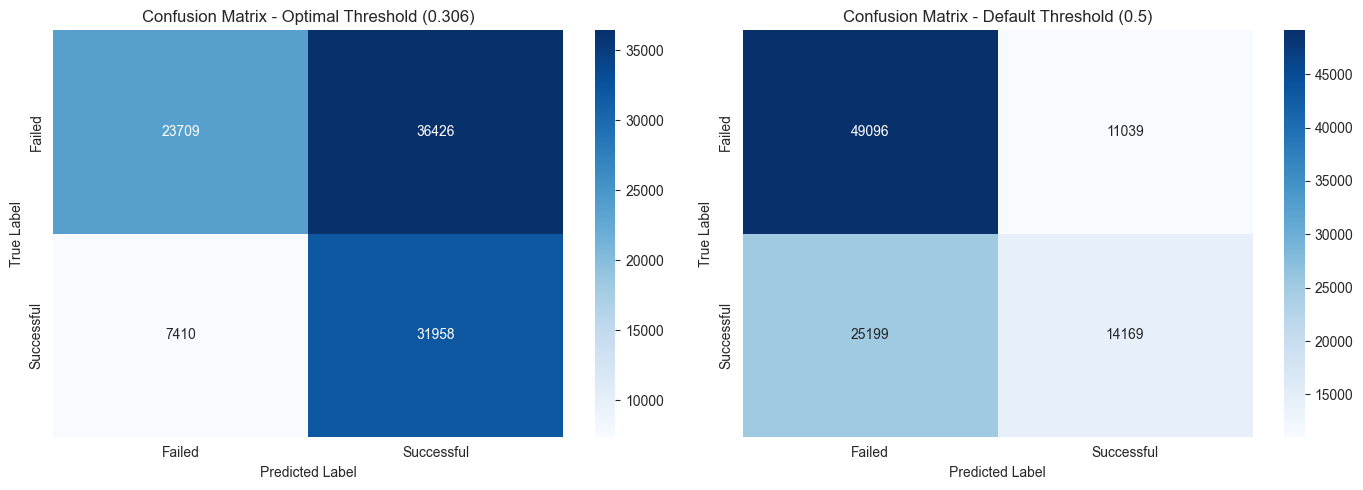


Confusion Matrix Breakdown (Optimal Threshold):
True Negatives (Correctly predicted failures): 23,709
False Positives (Predicted success, actually failed): 36,426
False Negatives (Predicted failure, actually successful): 7,410
True Positives (Correctly predicted successes): 31,958


In [10]:
# Confusion Matrix at optimal threshold
cm_opt = confusion_matrix(y_test, y_test_pred_opt)
cm_default = confusion_matrix(y_test, y_test_pred_default)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Failed', 'Successful'],
            yticklabels=['Failed', 'Successful'])
axes[0].set_title(f'Confusion Matrix - Optimal Threshold ({optimal_threshold:.3f})')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Failed', 'Successful'],
            yticklabels=['Failed', 'Successful'])
axes[1].set_title('Confusion Matrix - Default Threshold (0.5)')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Print confusion matrix breakdown
tn, fp, fn, tp = cm_opt.ravel()
print("\nConfusion Matrix Breakdown (Optimal Threshold):")
print(f"True Negatives (Correctly predicted failures): {tn:,}")
print(f"False Positives (Predicted success, actually failed): {fp:,}")
print(f"False Negatives (Predicted failure, actually successful): {fn:,}")
print(f"True Positives (Correctly predicted successes): {tp:,}")


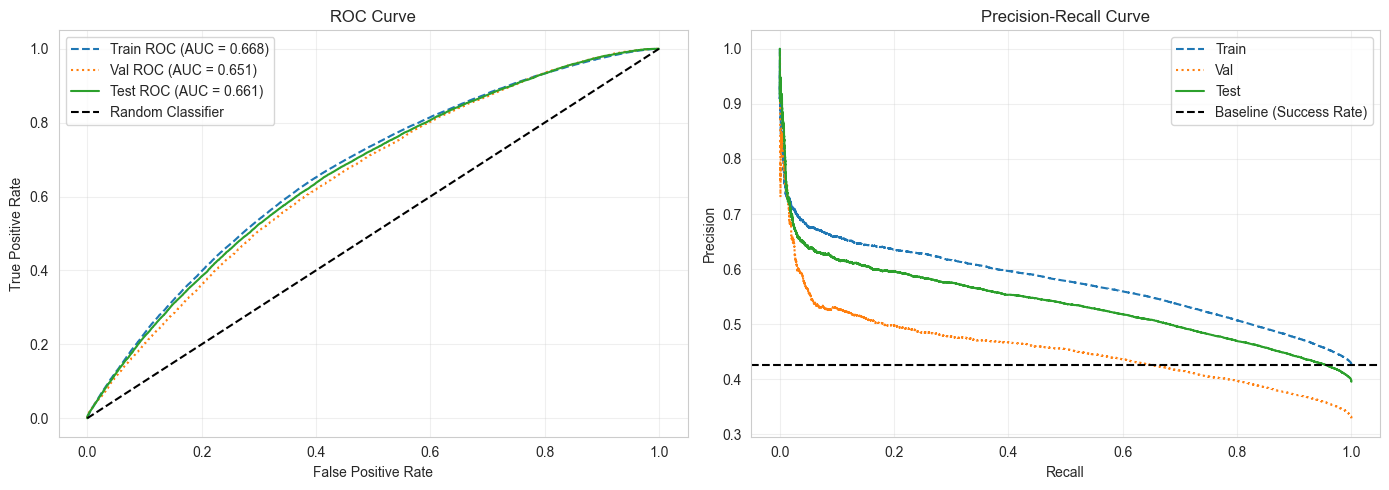

In [11]:
# ROC Curve and Precision-Recall Curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

axes[0].plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {train_roc_auc:.3f})', linestyle='--')
axes[0].plot(fpr_val, tpr_val, label=f'Val ROC (AUC = {val_roc_auc:.3f})', linestyle=':')
axes[0].plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {test_roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
prec_train, rec_train, _ = precision_recall_curve(y_train, y_train_proba)
prec_val, rec_val, _ = precision_recall_curve(y_val, y_val_proba)
prec_test, rec_test, _ = precision_recall_curve(y_test, y_test_proba)

axes[1].plot(rec_train, prec_train, label='Train', linestyle='--')
axes[1].plot(rec_val, prec_val, label='Val', linestyle=':')
axes[1].plot(rec_test, prec_test, label='Test')
axes[1].axhline(y=y_train.mean(), color='k', linestyle='--', label='Baseline (Success Rate)')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Feature Importance Analysis

Logistic Regression coefficients can help us understand which features are most important for predicting success.


In [12]:
# Get feature coefficients
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': lr_model.coef_[0]
})

# Sort by absolute value of coefficient
feature_importance['abs_coefficient'] = feature_importance['coefficient'].abs()
feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)

print("Top 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))


Top 20 Most Important Features:
                            feature  coefficient  abs_coefficient
main_category_grouped_Entertainment     0.805763         0.805763
                       log_usd_goal    -0.441073         0.441073
            continent_North America     0.408269         0.408269
     main_category_grouped_Creative     0.351847         0.351847
                   launched_month_3     0.314580         0.314580
                  continent_Oceania    -0.279672         0.279672
                   launched_month_4     0.261122         0.261122
                   launched_month_7    -0.259655         0.259655
                      duration_days    -0.227841         0.227841
                   launched_month_5     0.188081         0.188081
                   launched_month_6     0.153978         0.153978
                   launched_month_2     0.122785         0.122785
         main_category_grouped_Tech     0.106510         0.106510
                  launched_month_10     0.10

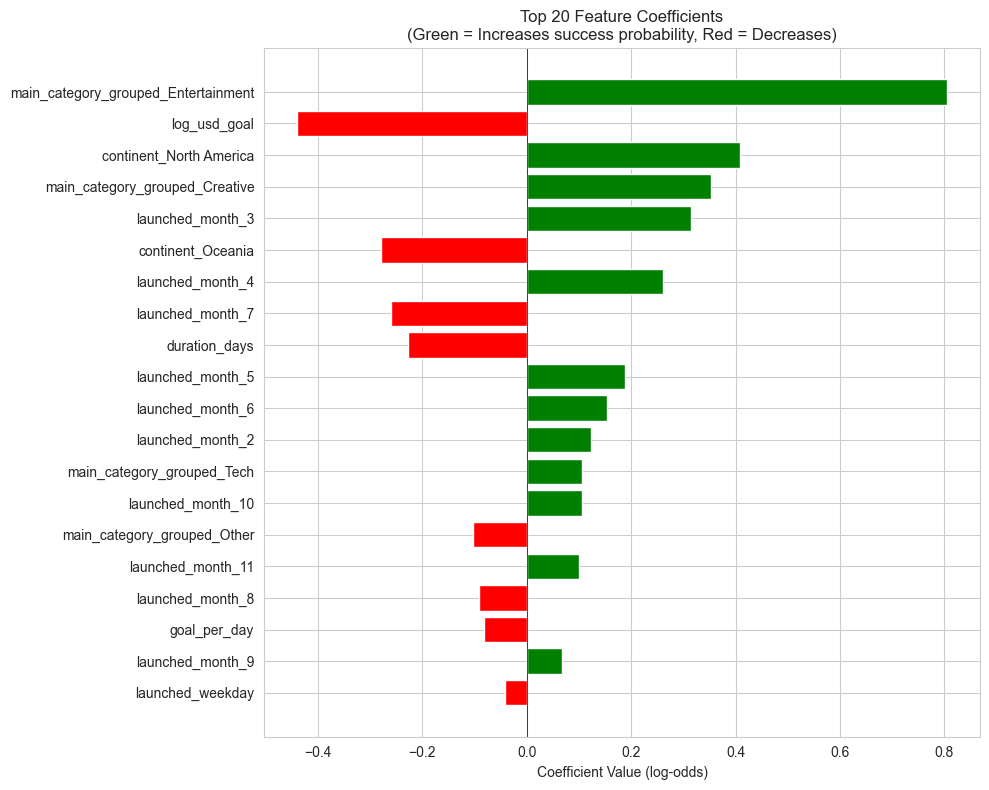

In [13]:
# Visualize top features
top_n = min(20, len(feature_importance))
top_features = feature_importance.head(top_n)

plt.figure(figsize=(10, 8))
colors = ['green' if x > 0 else 'red' for x in top_features['coefficient']]
plt.barh(range(len(top_features)), top_features['coefficient'], color=colors)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient Value (log-odds)')
plt.title(f'Top {top_n} Feature Coefficients\n(Green = Increases success probability, Red = Decreases)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
